In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy import stats
import psycopg2
from psycopg2.extras import execute_batch
from psycopg2.extras import execute_values
from sqlalchemy import create_engine
from psycopg2 import sql
from psycopg2.extras import execute_values
import logging
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [23]:
class SMART:
    
    def __init__(self, filepath: str):
        """Initialize SMART object by reading a CSV file into a pandas DataFrame."""
        self.filepath = filepath
        self.data = pd.read_csv(filepath)

    # ===== BASIC INSPECTION ===== #
    def Data_frame(self):
        """Return the entire DataFrame."""
        return self.data

    def Count_of_rows_columns(self):
        """Return the number of rows and columns as a tuple."""
        return self.data.shape

    def Columns(self):
        """Return the list of column names."""
        return self.data.columns

    def Data_info(self):
        """Print info about the DataFrame (dtypes, non-nulls)."""
        return self.data.info()

    def Last_elements(self):
        """Return the last 10 rows of the DataFrame."""
        return self.data.tail(10)

    # ===== DATA CLEANING ===== #
    def Check_nulls(self):
        """Return the number of null values per column."""
        return self.data.isnull().sum()

    def Percentage_of_nulls(self):
        """Return the percentage of null values per column."""
        return (self.data.isnull().sum() / len(self.data)) * 100

    def Fill_null(self):
        """Fill null values with mode (categorical) or median (numeric)."""
        categorical_cols = self.data.select_dtypes(include=["object", "category"]).columns
        numeric_cols = self.data.select_dtypes(include=["number"]).columns

        self.data[categorical_cols] = self.data[categorical_cols].apply(
            lambda x: x.fillna(x.mode()[0])
        )
        self.data[numeric_cols] = self.data[numeric_cols].apply(
            lambda x: x.fillna(x.median())
        )
        return self.data

    def Replacing(self, col):
        """Replace 'ERROR' with NaN, convert column to numeric, and fill with mean."""
        self.data[col] = self.data[col].replace("ERROR", None)
        self.data[col] = pd.to_numeric(self.data[col], errors="coerce")
        self.data[col] = self.data[col].fillna(self.data[col].mean())
        return self.data

    def Remove_underscore(self, col):
        """Remove underscores from string values in a column."""
        self.data[col] = self.data[col].str.replace("_", " ", regex=False)
        return self.data

    def standardize_activity_level(self):
        """
        Standardize entries in the 'Activity Level' column by:
        - Converting text to lowercase
        - Replacing underscores with spaces
        - Trimming leading/trailing whitespace
        - Mapping known incorrect or variant labels to canonical forms
        """
        self.data['Activity Level'] = self.data['Activity Level'].str.lower()
        self.data['Activity Level'] = self.data['Activity Level'].str.replace('_', ' ')
        self.data['Activity Level'] = self.data['Activity Level'].str.strip()
        self.data['Activity Level'] = self.data['Activity Level'].replace({
            'actve': 'active',
            'seddentary': 'sedentary',
            'highly active': 'highly active',
            'highly_active': 'highly active',
            'sedentary': 'sedentary',
            'active': 'active'
        })
    def convert_dtype(self, col):
        """Convert a column to numeric, coercing invalid values to NaN."""
        self.data[col] = pd.to_numeric(self.data[col], errors="coerce")
        return self.data

    def Unique(self, col):
        """Print unique values and null count of a column."""
        print(self.data[col].unique())
        print(f"Nulls in {col}: {self.data[col].isna().sum()}")
        return

    def Filling(self, col):
        """Fill null values in a column with its mode."""
        self.data[col] = self.data[col].fillna(self.data[col].mode()[0])
        return self.data

    # ===== STATISTICAL ANALYSIS ===== #
    def Stat_info(self):
        """Return descriptive statistics of numeric columns."""
        return self.data.describe()

    def Measures(self):
        """Return a DataFrame with mean, median, mode, variance, and std dev for numeric columns."""
        numeric_cols = self.data.select_dtypes(include=["int64", "float64"]).columns
        measures = []
        for col in numeric_cols:
            measures.append(
                {
                    "Column": col,
                    "Mean": self.data[col].mean(),
                    "Median": self.data[col].median(),
                    "Mode": self.data[col].mode()[0],
                    "Variance": self.data[col].var(),
                    "Std_Dev": self.data[col].std(),
                }
            )
        return pd.DataFrame(measures)

    def Correlation(self):
        """Print correlations of numeric columns with the 'Step Count' column."""
        target = "Step Count"
        continious_var = self.data.select_dtypes(include=["int64", "float64"]).columns
        for col in continious_var:
            if col != target:
                result = np.corrcoef(self.data[col], self.data[target])[0][1]
                print(f"{col} vs {target} => correlation: {round(result,3)}")
        return

    def Anova(self):
        """Perform ANOVA for categorical variables against 'Stress Level'."""
        target = "Stress Level"
        categorical_var = self.data.select_dtypes(include=["object"]).columns
        for col in categorical_var:
            groups = [group[target].values for _, group in self.data.groupby(col)]
            groups = [g for g in groups if len(g) > 1]
            if len(groups) >= 2:
                f_stat, p_val = stats.f_oneway(*groups)
                print(f"ANOVA {col}: F={f_stat:.3f}, p={p_val:.3e}")
            else:
                print(f"Skipping {col}")
        return

    def Chi_square(self):
        """Perform chi-square test between categorical variables and 'Activity Level'."""
        target = "Activity Level"
        categorical_vars = self.data.select_dtypes(include=["object", "category"]).columns
        results = []
        for col in categorical_vars:
            if col == target:
                continue
            table = pd.crosstab(self.data[col], self.data[target])
            if table.shape[0] > 1 and table.shape[1] > 1:
                chi2, p, dof, _ = chi2_contingency(table)
                interpretation = "Significant" if p < 0.05 else "Not Significant"
                results.append(
                    {
                        "Variable": col,
                        "Chi2": round(chi2, 3),
                        "p-Value": format(p, ".3e"),
                        "DF": dof,
                        "Interpretation": interpretation,
                    }
                )
        return pd.DataFrame(results)

    def Outliers(self, col):
        """Identify and return outliers using the IQR method."""
        Q1, Q3 = self.data[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers = self.data[(self.data[col] < lower) | (self.data[col] > upper)]
        print(f"Lower Bound: {lower}, Upper Bound: {upper}, Outliers: {len(outliers)}")
        return outliers

    # ===== VISUALIZATIONS ===== #
    def Hist_plot(self, col):
        """Plot a histogram for a numeric column."""
        plt.figure(figsize=(15, 10))
        sns.histplot(self.data[col], bins=30, kde=True, color="skyblue")
        plt.title(f"Distribution of {col}")
        plt.show()

    def Box_plot(self, col1, col2):
        """Plot a boxplot comparing two columns."""
        plt.figure(figsize=(15, 10))
        sns.boxplot(x=col1, y=col2, data=self.data, palette="Set2")
        plt.show()

    def Line_plot(self, col1, col2):
        """Plot lineplot for a column against another, using first 10 users."""
        top10_users = self.data["User ID"].unique()[:10]
        subset = self.data[self.data["User ID"].isin(top10_users)]
        plt.figure(figsize=(15, 10))
        sns.lineplot(x=col1, y=col2, data=subset, hue="User ID")
        plt.xticks(rotation=45)
        plt.show()

    def Scatter_plot(self, col1, col2):
        """Plot scatterplot of two numeric columns, colored by User ID."""
        plt.figure(figsize=(15, 10))
        sns.scatterplot(x=col1, y=col2, data=self.data, hue="User ID", alpha=0.7)
        plt.show()

    def Heat_map(self):
        """Plot heatmap of correlations between numeric columns."""
        plt.figure(figsize=(15, 10))
        sns.heatmap(self.data.corr(numeric_only=True), annot=True, cmap="coolwarm")
        plt.show()

    def Bar_chart(self, col1, col2):
        """Plot bar chart of average values of one column grouped by another."""
        plt.figure(figsize=(15, 10))
        avg_steps = self.data.groupby(col1)[col2].mean().reset_index()
        sns.barplot(x=col1, y=col2, data=avg_steps, palette="viridis")
        plt.show()

    def Violin_plot(self, col):
        """Plot violin plot for distribution of a column."""
        plt.figure(figsize=(15, 10))
        sns.violinplot(y=col, data=self.data, palette="muted")
        plt.show()

    def Pair_plot(self, columns):
        """Plot pairplot for selected columns."""
        sns.pairplot(self.data[columns].dropna(), diag_kind="kde")
        plt.show()

    def Kde_plot(self, col1, col2):
        """Plot KDE plot for one column grouped by another."""
        plt.figure(figsize=(15, 10))
        sns.kdeplot(data=self.data, x=col1, hue=col2, fill=True, alpha=0.4)
        plt.show()

    def Hexbin_jointplot(self, col1, col2):
        """Plot hexbin jointplot between two numeric columns."""
        sns.jointplot(data=self.data, x=col1, y=col2, kind="hex", cmap="Blues")
        plt.show()

    def Surface_plot(self, col1, col2, col3):
        """Plot 3D scatter plot using Plotly for three dimensions."""
        fig = px.scatter_3d(
            self.data, x=col1, y=col2, z=col3, color=col2,
            title="3D Scatter Plot"
        )
        fig.show()

    """ scaling """
    def std_scale(self):
        numeric = self.data.select_dtypes(exclude = 'object')
        scaler = StandardScaler()
        scaled = scaler.fit_transform(numeric)
        scaled_df = pd.DataFrame(scaled, columns=numeric.columns)
        return scaled_df

    def minmax_scale(self):
        numeric = self.data.select_dtypes(exclude = 'object')
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(numeric)
        scaled_df = pd.DataFrame(scaled, columns=numeric.columns)
        return scaled_df

    # ===== POSTGRESQL INTEGRATION ===== #
    @staticmethod
    def convert_intervals_to_str(df: pd.DataFrame) -> pd.DataFrame:
        """Convert Interval objects in a DataFrame to strings for compatibility."""
        def convert_val(x):
            if isinstance(x, pd._libs.interval.Interval):
                return str(x)
            return x
        df_copy = df.copy()
        for col in df_copy.columns:
            if isinstance(df_copy[col].dtype, pd.IntervalDtype):
                df_copy[col] = df_copy[col].astype(str)
            elif df_copy[col].dtype == "object":
                df_copy[col] = df_copy[col].apply(convert_val)
        return df_copy

    @staticmethod
    def infer_sql_type(dtype):
        """Infer SQL type from pandas dtype."""
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"

    def generate_create_table_statement(self, table_name="smartwatch_health_data"):
        """Generate a CREATE TABLE SQL statement for the DataFrame."""
        sql_columns = ",\n    ".join(
            [f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in self.data.dtypes.items()]
        )
        return f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            {sql_columns}
        );
        """

    def save_to_postgres(self, conn_params: dict, table_name="smartwatch_health_data"):
        """Save DataFrame to a PostgreSQL database."""
        create_stmt = self.generate_create_table_statement(table_name)
        conn, cur = None, None
        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            cur.execute(create_stmt)
            conn.commit()

            df_clean = self.convert_intervals_to_str(self.data)

            columns = list(df_clean.columns)
            placeholders = ", ".join(["%s"] * len(columns))
            insert_stmt = f"INSERT INTO {table_name} ({', '.join([f'\"{col}\"' for col in columns])}) VALUES ({placeholders})"

            execute_batch(cur, insert_stmt, [tuple(row) for row in df_clean.to_numpy()])
            conn.commit()
            print(f"Data inserted successfully into '{table_name}'")
        except Exception as e:
            print(f"Data inserted successfully into '{table_name}'")
            if conn:
                conn.rollback()
        finally:
            if cur:
                cur.close()
            if conn:
                conn.close()

    def save_cleaned_csv(self, filepath: str, run_cleaning: bool = True):
        """Save cleaned DataFrame to CSV file."""
        df_to_save = self.data.copy()
        if run_cleaning:
            df_to_save = self.Fill_null()
            df_to_save = self.convert_intervals_to_str(df_to_save)
        df_to_save.to_csv(filepath, index=False)
        print(f"Cleaned data saved to {filepath}")

In [24]:
s = SMART("Smart_Watch_data.csv")



# BASIC INSPECTION

In [25]:
s.Data_frame()

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0      4174.0         58.939776               98.809650   5450.390578   
1      2998.0         75.220601               98.532195    727.601610   
2      1860.0        247.803052               97.052954   2826.521994   
3      2294.0         40.000000               96.894213  13797.338044   
4      2130.0         61.950165               98.583797  15679.067648   
...       ...               ...                     ...           ...   
9995   1524.0         78.819386               98.931927   2948.491953   
9996   4879.0         48.632659               95.773035   4725.623070   
9997   2624.0         73.834442               97.945874   2571.492060   
9998   4907.0         75.220601               98.401058   3364.788855   
9999   4113.0         70.063864               98.475606    544.696104   

      Sleep Duration (hours) Activity Level  Stress Level  
0                   7.167236  highly active           1.0  
1                   6.538239  highly active           5.0  
2                   6.505463  highly active           5.0  
3                   7.367790         active           3.0  
4                   6.505463  highly active           6.0  
...                      ...            ...           ...  
9995                7.402749         active           7.0  
9996                6.382166      sedentary           2.0  
9997                6.916549      sedentary           4.0  
9998                5.691234         active           8.0  
9999                5.691001         active           5.0  

[10000 rows x 7 columns]

In [26]:
s.Count_of_rows_columns()

(10000, 7)

In [27]:
s.Columns()

Index(['User ID', 'Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)', 'Activity Level', 'Stress Level'],
      dtype='object')

In [28]:
s.Data_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 10000 non-null  float64
 1   Heart Rate (BPM)        10000 non-null  float64
 2   Blood Oxygen Level (%)  10000 non-null  float64
 3   Step Count              10000 non-null  float64
 4   Sleep Duration (hours)  10000 non-null  float64
 5   Activity Level          10000 non-null  object 
 6   Stress Level            10000 non-null  float64
dtypes: float64(6), object(1)
memory usage: 547.0+ KB


In [29]:
s.Last_elements()

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
9990   2998.0         75.220601              100.000000   3817.269018   
9991   4289.0         91.381582               95.741838   3930.126338   
9992   2998.0         77.456034               99.643309   1102.662786   
9993   2184.0         69.669424               96.385686     94.980639   
9994   1942.0         77.912299               98.640583  10061.145291   
9995   1524.0         78.819386               98.931927   2948.491953   
9996   4879.0         48.632659               95.773035   4725.623070   
9997   2624.0         73.834442               97.945874   2571.492060   
9998   4907.0         75.220601               98.401058   3364.788855   
9999   4113.0         70.063864               98.475606    544.696104   

      Sleep Duration (hours) Activity Level  Stress Level  
9990                8.595260      sedentary           2.0  
9991                5.804083      sedentary           8.0  
9992                9.484019      sedentary           9.0  
9993                5.923017      sedentary           7.0  
9994                5.428635      sedentary          10.0  
9995                7.402749         active           7.0  
9996                6.382166      sedentary           2.0  
9997                6.916549      sedentary           4.0  
9998                5.691234         active           8.0  
9999                5.691001         active           5.0

# DATA CLEANING

In [30]:
s.Check_nulls()


User ID                   0
Heart Rate (BPM)          0
Blood Oxygen Level (%)    0
Step Count                0
Sleep Duration (hours)    0
Activity Level            0
Stress Level              0
dtype: int64

In [31]:
s.Percentage_of_nulls()

User ID                   0.0
Heart Rate (BPM)          0.0
Blood Oxygen Level (%)    0.0
Step Count                0.0
Sleep Duration (hours)    0.0
Activity Level            0.0
Stress Level              0.0
dtype: float64

In [32]:
s.Fill_null()

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0      4174.0         58.939776               98.809650   5450.390578   
1      2998.0         75.220601               98.532195    727.601610   
2      1860.0        247.803052               97.052954   2826.521994   
3      2294.0         40.000000               96.894213  13797.338044   
4      2130.0         61.950165               98.583797  15679.067648   
...       ...               ...                     ...           ...   
9995   1524.0         78.819386               98.931927   2948.491953   
9996   4879.0         48.632659               95.773035   4725.623070   
9997   2624.0         73.834442               97.945874   2571.492060   
9998   4907.0         75.220601               98.401058   3364.788855   
9999   4113.0         70.063864               98.475606    544.696104   

      Sleep Duration (hours) Activity Level  Stress Level  
0                   7.167236  highly active           1.0  
1                   6.538239  highly active           5.0  
2                   6.505463  highly active           5.0  
3                   7.367790         active           3.0  
4                   6.505463  highly active           6.0  
...                      ...            ...           ...  
9995                7.402749         active           7.0  
9996                6.382166      sedentary           2.0  
9997                6.916549      sedentary           4.0  
9998                5.691234         active           8.0  
9999                5.691001         active           5.0  

[10000 rows x 7 columns]

In [33]:
s.Check_nulls()

User ID                   0
Heart Rate (BPM)          0
Blood Oxygen Level (%)    0
Step Count                0
Sleep Duration (hours)    0
Activity Level            0
Stress Level              0
dtype: int64

In [34]:
s.Replacing("Sleep Duration (hours)")

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0      4174.0         58.939776               98.809650   5450.390578   
1      2998.0         75.220601               98.532195    727.601610   
2      1860.0        247.803052               97.052954   2826.521994   
3      2294.0         40.000000               96.894213  13797.338044   
4      2130.0         61.950165               98.583797  15679.067648   
...       ...               ...                     ...           ...   
9995   1524.0         78.819386               98.931927   2948.491953   
9996   4879.0         48.632659               95.773035   4725.623070   
9997   2624.0         73.834442               97.945874   2571.492060   
9998   4907.0         75.220601               98.401058   3364.788855   
9999   4113.0         70.063864               98.475606    544.696104   

      Sleep Duration (hours) Activity Level  Stress Level  
0                   7.167236  highly active           1.0  
1                   6.538239  highly active           5.0  
2                   6.505463  highly active           5.0  
3                   7.367790         active           3.0  
4                   6.505463  highly active           6.0  
...                      ...            ...           ...  
9995                7.402749         active           7.0  
9996                6.382166      sedentary           2.0  
9997                6.916549      sedentary           4.0  
9998                5.691234         active           8.0  
9999                5.691001         active           5.0  

[10000 rows x 7 columns]

In [35]:
s.Remove_underscore("Activity Level")

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0      4174.0         58.939776               98.809650   5450.390578   
1      2998.0         75.220601               98.532195    727.601610   
2      1860.0        247.803052               97.052954   2826.521994   
3      2294.0         40.000000               96.894213  13797.338044   
4      2130.0         61.950165               98.583797  15679.067648   
...       ...               ...                     ...           ...   
9995   1524.0         78.819386               98.931927   2948.491953   
9996   4879.0         48.632659               95.773035   4725.623070   
9997   2624.0         73.834442               97.945874   2571.492060   
9998   4907.0         75.220601               98.401058   3364.788855   
9999   4113.0         70.063864               98.475606    544.696104   

      Sleep Duration (hours) Activity Level  Stress Level  
0                   7.167236  highly active           1.0  
1                   6.538239  highly active           5.0  
2                   6.505463  highly active           5.0  
3                   7.367790         active           3.0  
4                   6.505463  highly active           6.0  
...                      ...            ...           ...  
9995                7.402749         active           7.0  
9996                6.382166      sedentary           2.0  
9997                6.916549      sedentary           4.0  
9998                5.691234         active           8.0  
9999                5.691001         active           5.0  

[10000 rows x 7 columns]

In [36]:
s.standardize_activity_level()

In [37]:
s.convert_dtype("Stress Level")

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0      4174.0         58.939776               98.809650   5450.390578   
1      2998.0         75.220601               98.532195    727.601610   
2      1860.0        247.803052               97.052954   2826.521994   
3      2294.0         40.000000               96.894213  13797.338044   
4      2130.0         61.950165               98.583797  15679.067648   
...       ...               ...                     ...           ...   
9995   1524.0         78.819386               98.931927   2948.491953   
9996   4879.0         48.632659               95.773035   4725.623070   
9997   2624.0         73.834442               97.945874   2571.492060   
9998   4907.0         75.220601               98.401058   3364.788855   
9999   4113.0         70.063864               98.475606    544.696104   

      Sleep Duration (hours) Activity Level  Stress Level  
0                   7.167236  highly active           1.0  
1                   6.538239  highly active           5.0  
2                   6.505463  highly active           5.0  
3                   7.367790         active           3.0  
4                   6.505463  highly active           6.0  
...                      ...            ...           ...  
9995                7.402749         active           7.0  
9996                6.382166      sedentary           2.0  
9997                6.916549      sedentary           4.0  
9998                5.691234         active           8.0  
9999                5.691001         active           5.0  

[10000 rows x 7 columns]

In [38]:
s.Unique("Stress Level")

[ 1.  5.  3.  6. 10.  2.  8.  9.  4.  7.]
Nulls in Stress Level: 0


In [39]:
s.Filling("Stress Level")

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0      4174.0         58.939776               98.809650   5450.390578   
1      2998.0         75.220601               98.532195    727.601610   
2      1860.0        247.803052               97.052954   2826.521994   
3      2294.0         40.000000               96.894213  13797.338044   
4      2130.0         61.950165               98.583797  15679.067648   
...       ...               ...                     ...           ...   
9995   1524.0         78.819386               98.931927   2948.491953   
9996   4879.0         48.632659               95.773035   4725.623070   
9997   2624.0         73.834442               97.945874   2571.492060   
9998   4907.0         75.220601               98.401058   3364.788855   
9999   4113.0         70.063864               98.475606    544.696104   

      Sleep Duration (hours) Activity Level  Stress Level  
0                   7.167236  highly active           1.0  
1                   6.538239  highly active           5.0  
2                   6.505463  highly active           5.0  
3                   7.367790         active           3.0  
4                   6.505463  highly active           6.0  
...                      ...            ...           ...  
9995                7.402749         active           7.0  
9996                6.382166      sedentary           2.0  
9997                6.916549      sedentary           4.0  
9998                5.691234         active           8.0  
9999                5.691001         active           5.0  

[10000 rows x 7 columns]

# STATISTICAL ANALYSIS 

In [40]:
s.Stat_info()

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
count  10000.000000      10000.000000            10000.000000  10000.000000   
mean    3007.289700         76.002867               97.846653   6965.454372   
std     1138.959109         19.020902                1.706913   6854.247583   
min     1001.000000         40.000000               90.791208      0.910138   
25%     2016.000000         65.322796               96.703718   2037.300857   
50%     2998.000000         75.220601               98.010642   4962.534599   
75%     3985.000000         84.791711               99.327856   9680.097095   
max     4999.000000        296.593970              100.000000  62486.690753   

       Sleep Duration (hours)  Stress Level  
count            10000.000000  10000.000000  
mean                 6.505463      5.377800  
std                  1.479748      2.886503  
min                 -0.194453      1.000000  
25%                  5.541519      3.000000  
50%                  6.505463      5.000000  
75%                  7.476227      8.000000  
max                 12.140233     10.000000

In [41]:
s.Measures()

Column         Mean       Median         Mode  \
0                 User ID  3007.289700  2998.000000  2998.000000   
1        Heart Rate (BPM)    76.002867    75.220601    75.220601   
2  Blood Oxygen Level (%)    97.846653    98.010642   100.000000   
3              Step Count  6965.454372  4962.534599  4962.534599   
4  Sleep Duration (hours)     6.505463     6.505463     6.505463   
5            Stress Level     5.377800     5.000000     2.000000   

       Variance      Std_Dev  
0  1.297228e+06  1138.959109  
1  3.617947e+02    19.020902  
2  2.913551e+00     1.706913  
3  4.698071e+07  6854.247583  
4  2.189655e+00     1.479748  
5  8.331900e+00     2.886503

In [42]:
s.Correlation()

User ID vs Step Count => correlation: 0.016
Heart Rate (BPM) vs Step Count => correlation: 0.014
Blood Oxygen Level (%) vs Step Count => correlation: -0.005
Sleep Duration (hours) vs Step Count => correlation: 0.008
Stress Level vs Step Count => correlation: 0.005


In [43]:
s.Anova()

ANOVA Activity Level: F=0.144, p=8.657e-01


In [44]:
s.Chi_square()

Empty DataFrame
Columns: []
Index: []

In [45]:
s.Outliers("Blood Oxygen Level (%)")

Lower Bound: 92.7675119453897, Upper Bound: 103.26406264360237, Outliers: 35


User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
39     1474.0         67.404282               92.655673   2830.668684   
389    4991.0         89.812696               92.003999   3197.915998   
548    1833.0         78.880652               92.109389   2274.291267   
736    4267.0         61.425090               92.614586   6512.104640   
773    3914.0         74.337231               92.288167   2482.815316   
859    2388.0         43.259383               92.482382    994.697587   
944    3703.0         84.058395               91.062167   9390.095074   
1129   4579.0         72.291005               92.577289    158.463338   
1179   3692.0         89.396977               91.507534   2790.919612   
1778   1395.0         74.038855               92.483740   4962.534599   
1857   1454.0         76.608650               92.644699   7032.122278   
2263   1425.0         43.767314               92.282996   3069.225843   
2316   2265.0        102.533707               91.514026   1015.818664   
2443   3253.0         52.514029               92.368105   3488.384199   
2698   3113.0         78.345556               91.034463  15758.278107   
3492   3514.0        100.075149               92.723995  10971.334467   
4048   2749.0         87.110612               92.192058  18406.286003   
4114   1258.0         97.254386               92.488127   5227.457798   
4323   4789.0         55.749120               91.717629   1539.251521   
5138   3998.0         79.414789               91.818093   9767.409192   
5472   2998.0         75.724488               92.000571   2030.131935   
5643   4354.0         85.644407               91.461562   5641.687332   
6105   1337.0         40.000000               92.144652   5534.234406   
7079   2150.0         61.665881               92.418695  20024.639989   
7428   1959.0         75.990920               91.785862    128.809348   
7509   3073.0         60.070434               91.858473   1673.030268   
7693   2279.0         59.304401               92.580825    914.629470   
7806   2094.0         81.651301               91.788210   7619.849709   
8170   1705.0         77.218179               92.009195   3153.222280   
9007   1110.0         54.061581               92.159270  15096.038740   
9102   2722.0         57.856078               92.584947  14187.533524   
9515   4003.0         77.049247               92.672066    681.142342   
9553   1992.0         72.889579               91.973218   2367.280481   
9577   2341.0         61.844491               90.791208   9594.119586   
9797   4342.0         57.523789               92.289059   7163.497538   

      Sleep Duration (hours) Activity Level  Stress Level  
39                  4.827592      sedentary           7.0  
389                 6.867674      sedentary           7.0  
548                 6.833726      sedentary           4.0  
736                 5.855441  highly active           4.0  
773                 7.455631         active           5.0  
859                 4.913507  highly active          10.0  
944                 4.550439         active           4.0  
1129                8.951708         active           5.0  
1179                5.617239      sedentary           8.0  
1778                5.299209      sedentary           9.0  
1857                8.256489         active           3.0  
2263                6.116160         active           1.0  
2316                6.769491         active           1.0  
2443                4.554556      sedentary           1.0  
2698                5.688178  highly active           1.0  
3492                6.071915  highly active           1.0  
4048                4.813027      sedentary           7.0  
4114                6.150836      sedentary           8.0  
4323                5.514930      sedentary           5.0  
5138                8.001758         active           5.0  
5472                6.618799      sedentary           9.0  
5643                7.078524  highly active           2.0

# VISUALIZATIONS


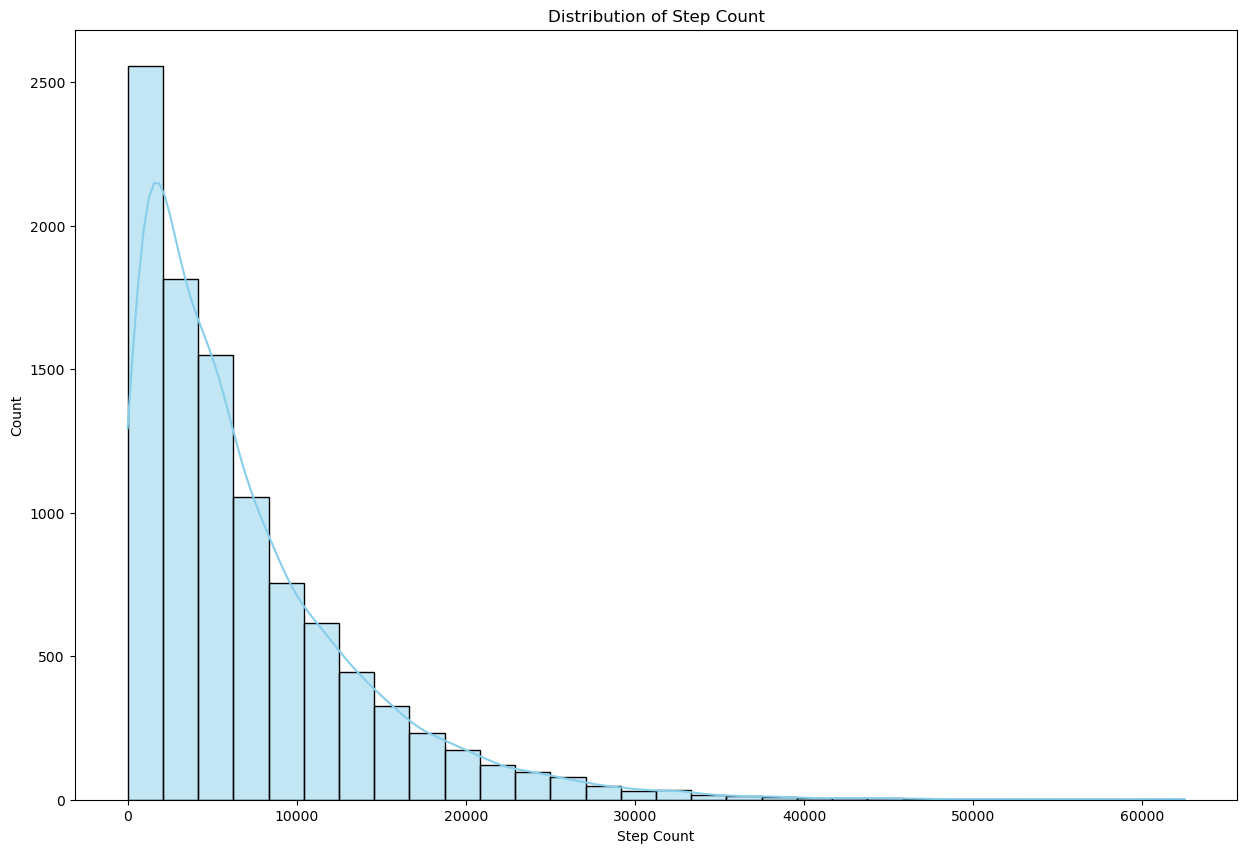

In [46]:
s.Hist_plot("Step Count")

C:\Users\rosan\AppData\Local\Temp\ipykernel_7780\1472147809.py:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=self.data, palette="Set2")


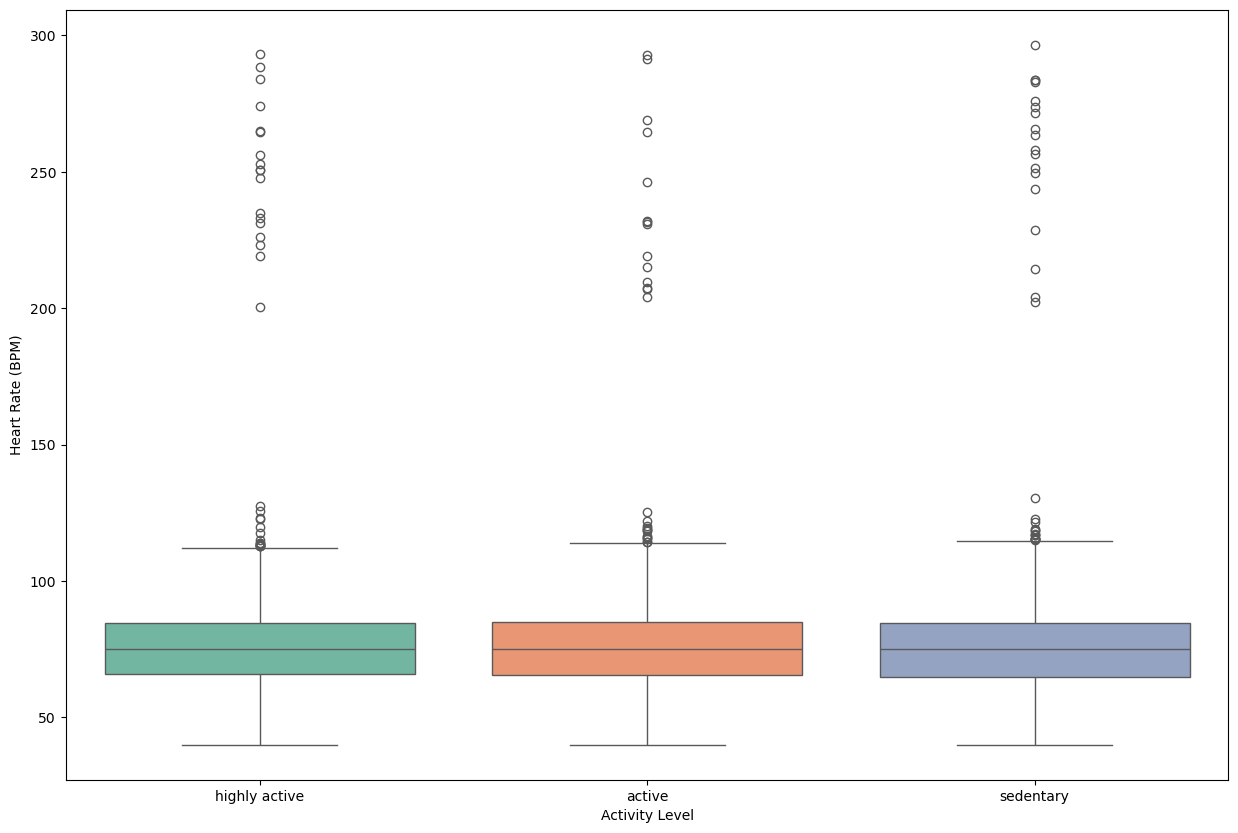

In [47]:
s.Box_plot("Activity Level","Heart Rate (BPM)")

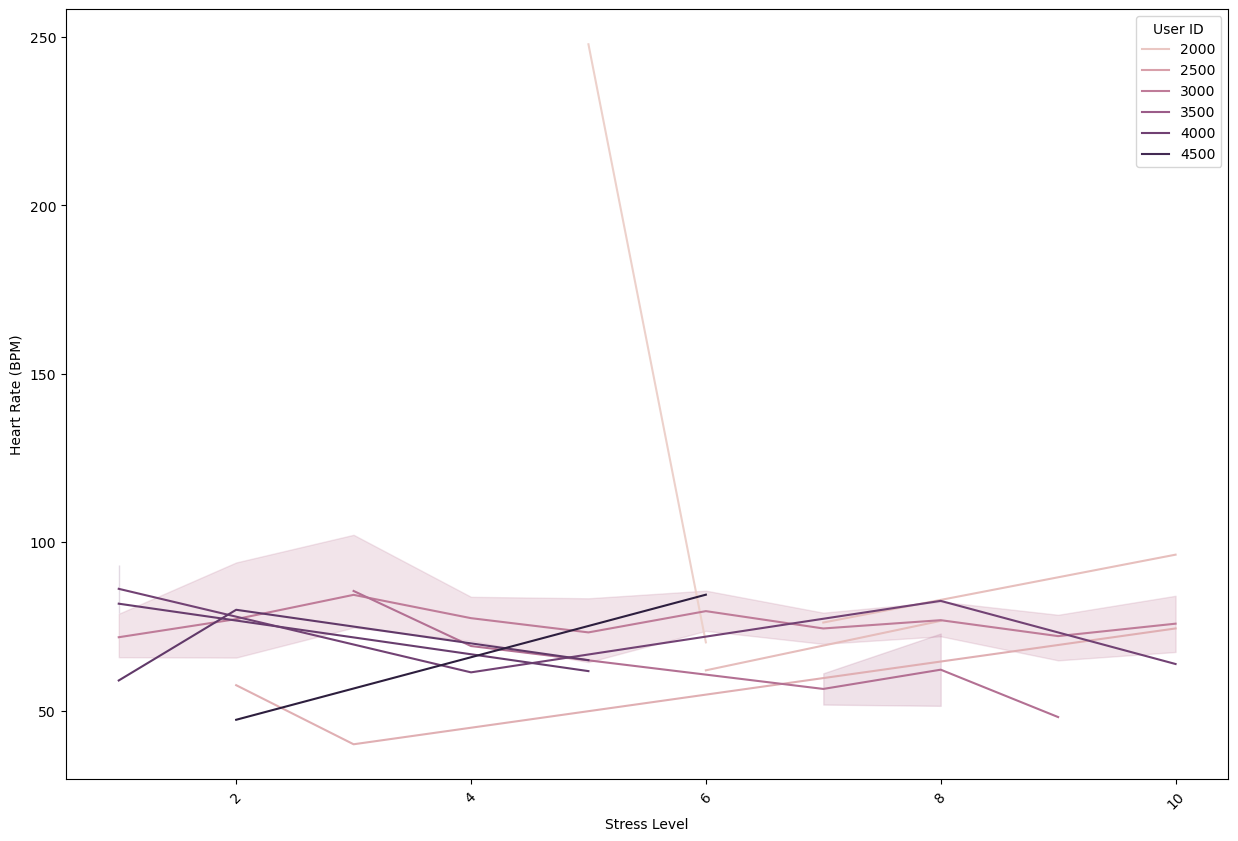

In [48]:
s.Line_plot("Stress Level","Heart Rate (BPM)")

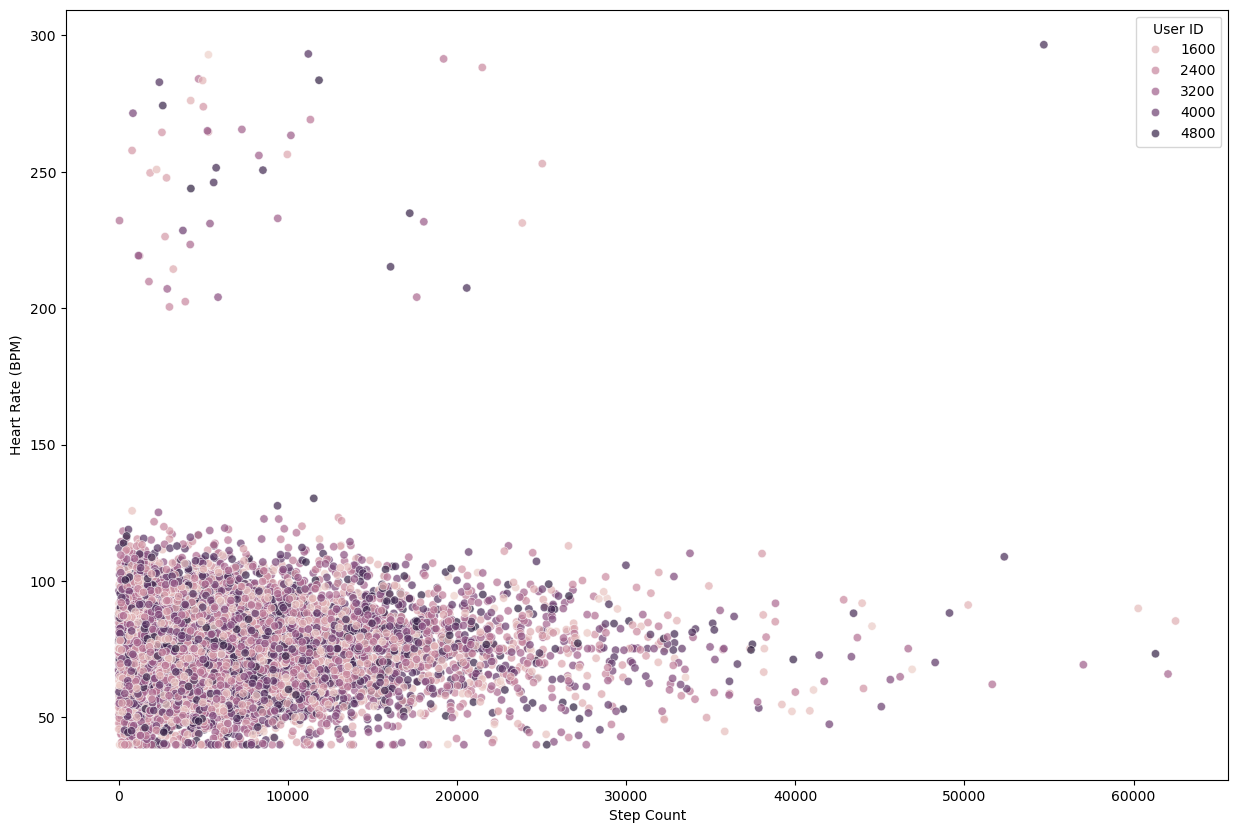

In [49]:
s.Scatter_plot("Step Count","Heart Rate (BPM)")

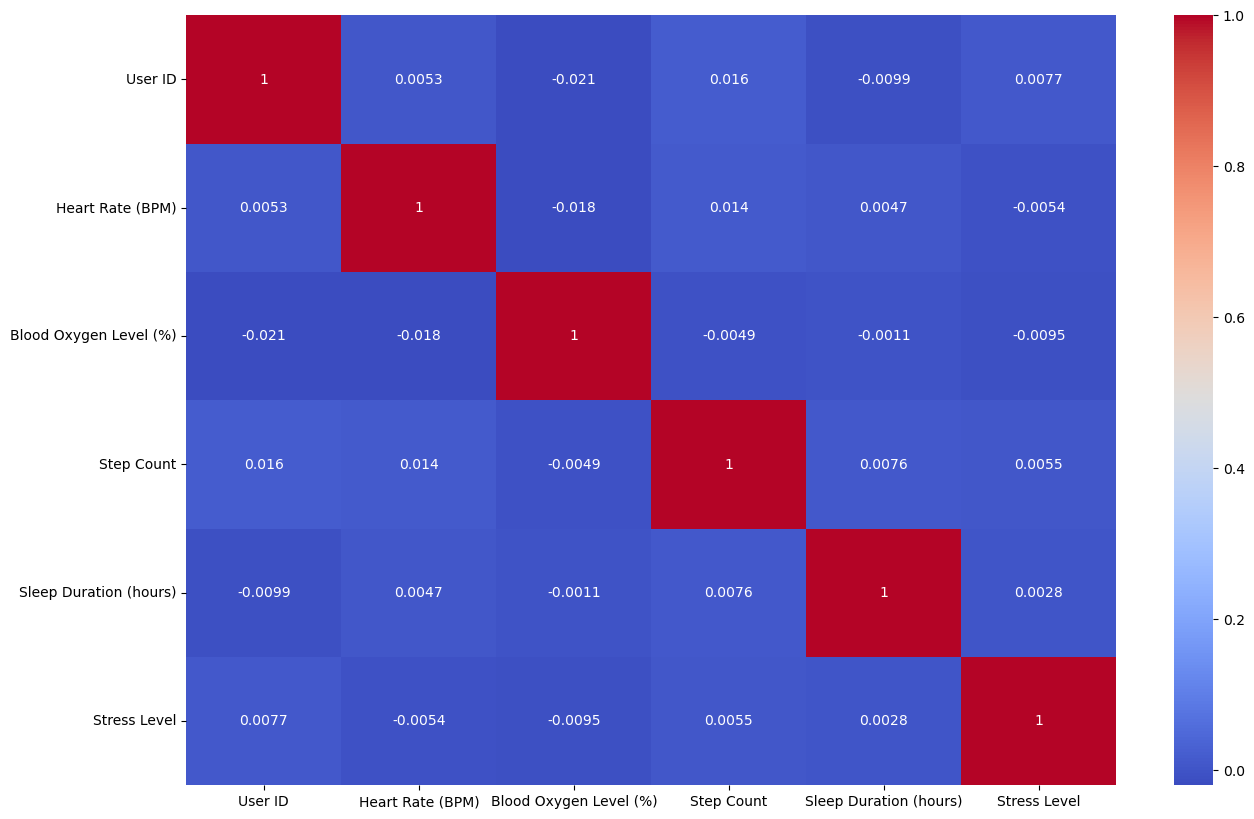

In [50]:
s.Heat_map()

C:\Users\rosan\AppData\Local\Temp\ipykernel_7780\1472147809.py:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col1, y=col2, data=avg_steps, palette="viridis")


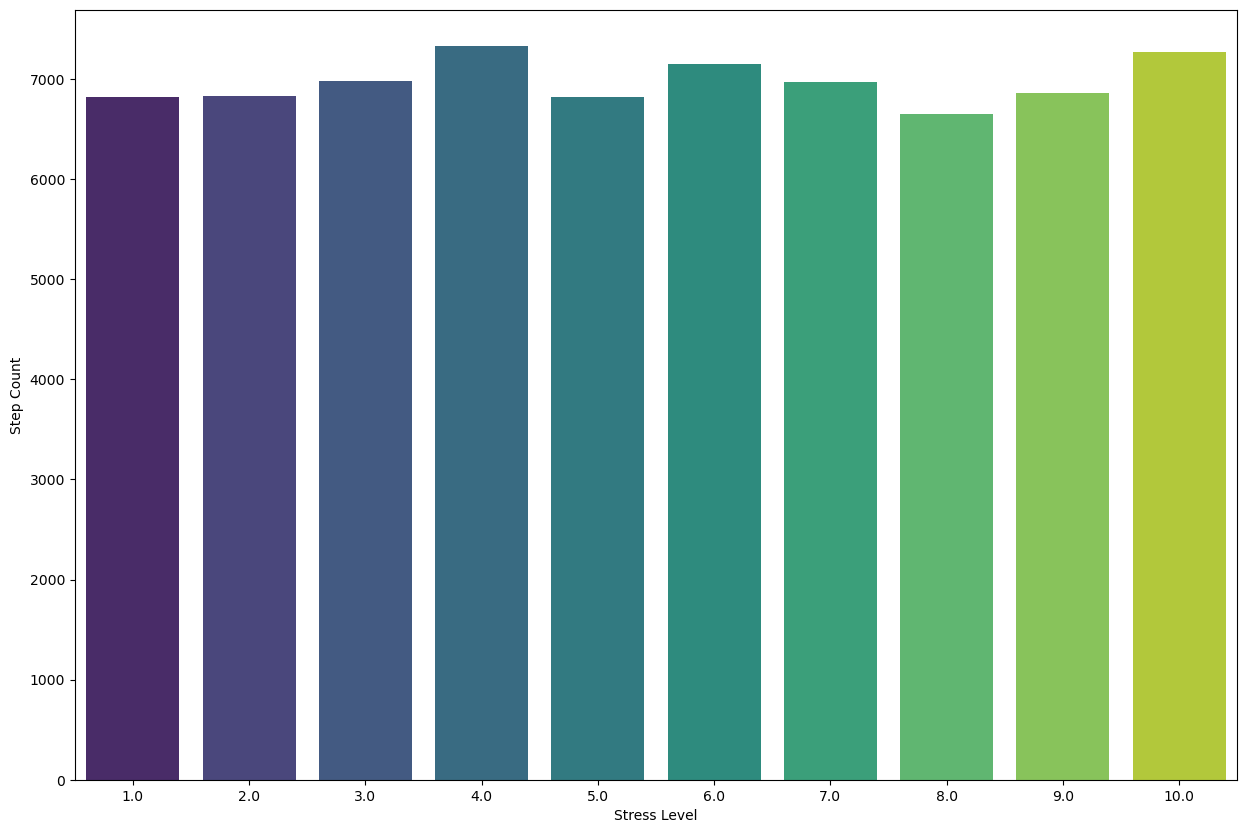

In [51]:
s.Bar_chart("Stress Level","Step Count")

C:\Users\rosan\AppData\Local\Temp\ipykernel_7780\1472147809.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=col, data=self.data, palette="muted")


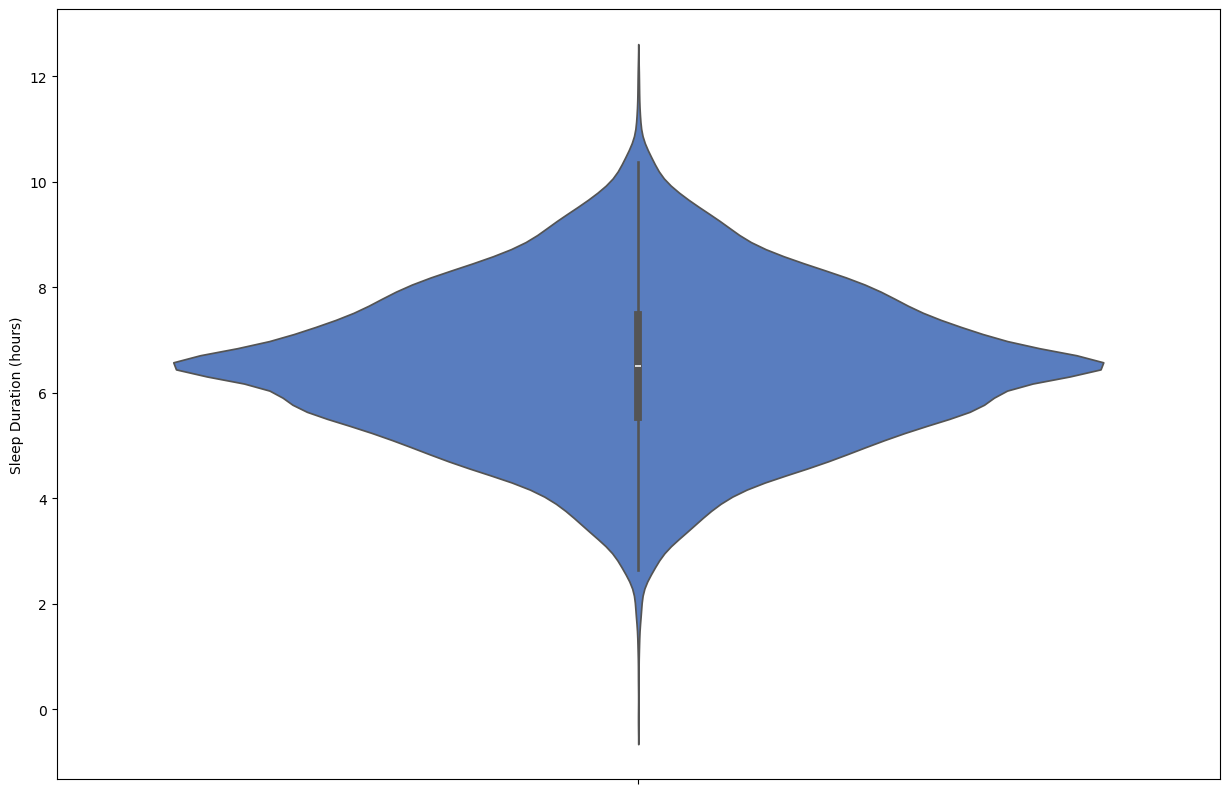

In [52]:
s.Violin_plot("Sleep Duration (hours)")

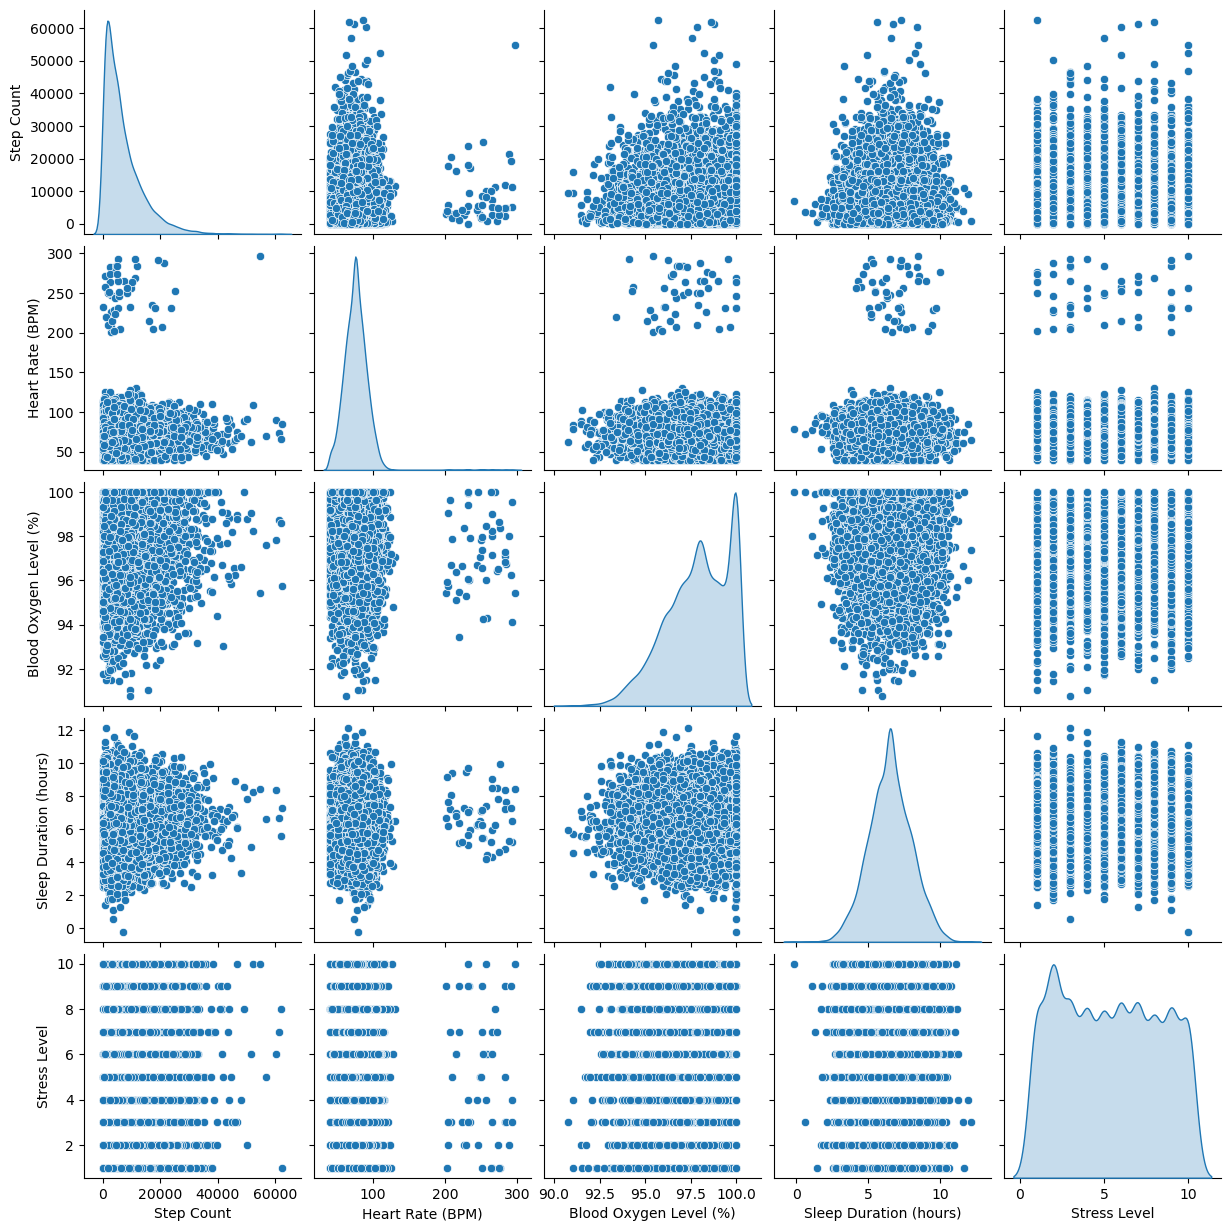

In [53]:
columns = ["Step Count", "Heart Rate (BPM)", "Blood Oxygen Level (%)", "Sleep Duration (hours)", "Stress Level"]
s.Pair_plot(columns)

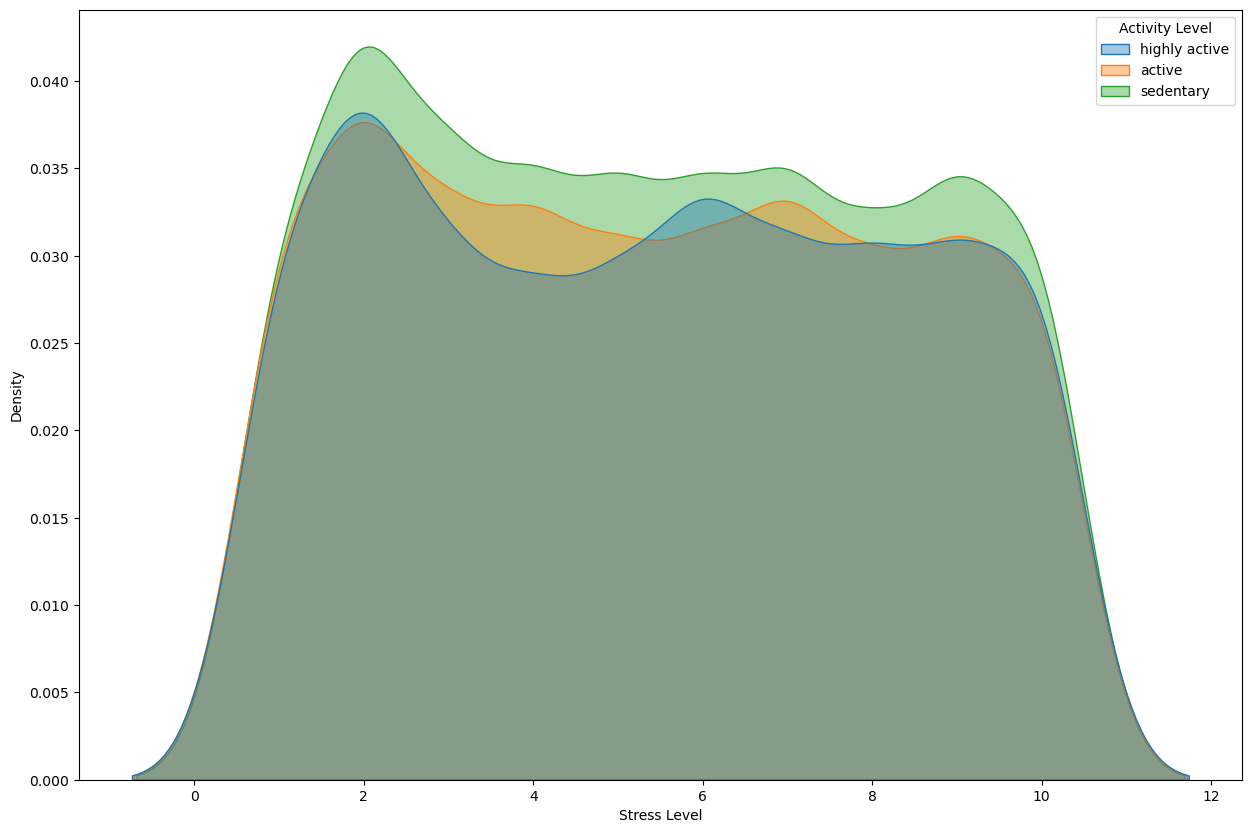

In [54]:
s.Kde_plot("Stress Level","Activity Level")

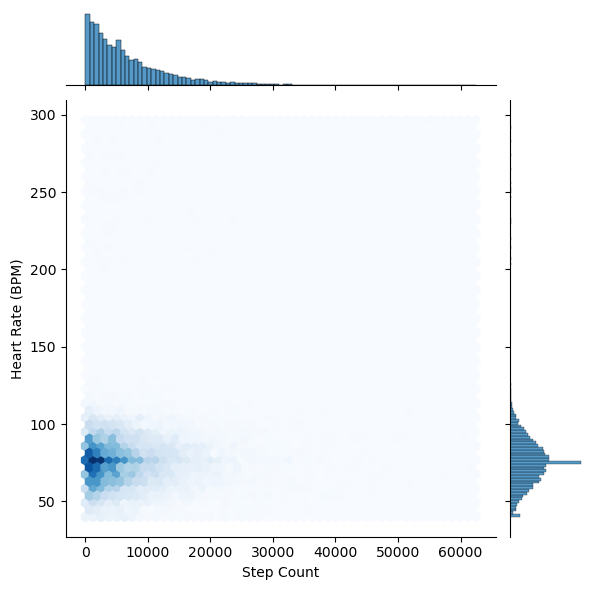

In [55]:
s.Hexbin_jointplot("Step Count","Heart Rate (BPM)")

In [56]:
s.Surface_plot("Heart Rate (BPM)", "Blood Oxygen Level (%)", "Step Count")

In [58]:
s.std_scale()

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)  Step Count  \
0     1.024417         -0.897115                0.564203   -0.221051   
1    -0.008157         -0.041129                0.401647   -0.910117   
2    -1.007365          9.032630               -0.465014   -0.603879   
3    -0.626296         -1.892900               -0.558017    0.996787   
4    -0.770294         -0.738840                0.431880    1.271336   
...        ...               ...                     ...         ...   
9995 -1.302386          0.148082                0.635843   -0.586084   
9996  1.643434         -1.439026               -1.214896   -0.326796   
9997 -0.336543         -0.114008                0.058132   -0.641089   
9998  1.668019         -0.041129                0.324816   -0.525345   
9999  0.970856         -0.312251                0.368492   -0.936803   

      Sleep Duration (hours)  Stress Level  
0                   0.447242     -1.516721  
1                   0.022151     -0.130892  
2                   0.000000     -0.130892  
3                   0.582781     -0.823806  
4                   0.000000      0.215566  
...                      ...           ...  
9995                0.606408      0.562023  
9996               -0.083327     -1.170263  
9997                0.277822     -0.477349  
9998               -0.550276      0.908480  
9999               -0.550433     -0.130892  

[10000 rows x 6 columns]

In [59]:
s.minmax_scale()

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)  Step Count  \
0     0.793647          0.073812                0.870738    0.087212   
1     0.499500          0.137262                0.840608    0.011630   
2     0.214857          0.809852                0.679975    0.045220   
3     0.323412          0.000000                0.662737    0.220793   
4     0.282391          0.085544                0.846212    0.250908   
...        ...               ...                     ...         ...   
9995  0.130815          0.151287                0.884016    0.047172   
9996  0.969985          0.033643                0.540986    0.075613   
9997  0.405953          0.131860                0.776939    0.041139   
9998  0.976988          0.137262                0.826368    0.053834   
9999  0.778389          0.117165                0.834463    0.008703   

      Sleep Duration (hours)  Stress Level  
0                   0.596828      0.000000  
1                   0.545834      0.444444  
2                   0.543177      0.444444  
3                   0.613088      0.222222  
4                   0.543177      0.555556  
...                      ...           ...  
9995                0.615922      0.666667  
9996                0.533181      0.111111  
9997                0.576505      0.333333  
9998                0.477166      0.777778  
9999                0.477147      0.444444  

[10000 rows x 6 columns]

In [57]:
print(s.generate_create_table_statement())


        CREATE TABLE IF NOT EXISTS smartwatch_health_data (
            "User ID" FLOAT,
    "Heart Rate (BPM)" FLOAT,
    "Blood Oxygen Level (%)" FLOAT,
    "Step Count" FLOAT,
    "Sleep Duration (hours)" FLOAT,
    "Activity Level" TEXT,
    "Stress Level" FLOAT
        );
        


In [37]:
s.convert_intervals_to_str(s.data)

User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0      4174.0         58.939776               98.809650   5450.390578   
1      2998.0         75.220601               98.532195    727.601610   
2      1860.0        247.803052               97.052954   2826.521994   
3      2294.0         40.000000               96.894213  13797.338044   
4      2130.0         61.950165               98.583797  15679.067648   
...       ...               ...                     ...           ...   
9995   1524.0         78.819386               98.931927   2948.491953   
9996   4879.0         48.632659               95.773035   4725.623070   
9997   2624.0         73.834442               97.945874   2571.492060   
9998   4907.0         75.220601               98.401058   3364.788855   
9999   4113.0         70.063864               98.475606    544.696104   

      Sleep Duration (hours) Activity Level  Stress Level  
0                   7.167236  highly active           1.0  
1                   6.538239  highly active           5.0  
2                   6.505463  highly active           5.0  
3                   7.367790         active           3.0  
4                   6.505463  highly active           6.0  
...                      ...            ...           ...  
9995                7.402749         active           7.0  
9996                6.382166      sedentary           2.0  
9997                6.916549      sedentary           4.0  
9998                5.691234         active           8.0  
9999                5.691001         active           5.0  

[10000 rows x 7 columns]

In [39]:
s.save_cleaned_csv("smartwatch_data.csv")

Cleaned data saved to smartwatch_data.csv
